In [2]:
from spectral import *
import spectral.io.envi as envi
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi




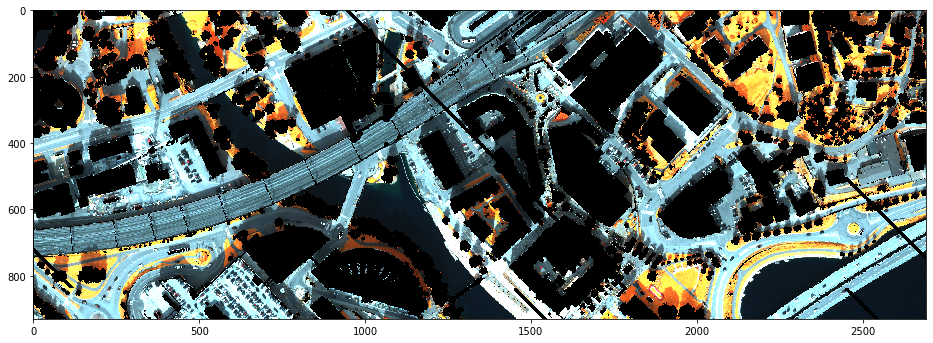

In [67]:
image = envi.open('../hyperImage/reflectance/09_VNIR_ROADMASKED_POLISHED.hdr', 
                  '../hyperImage/reflectance/09_VNIR_ROADMASKED_POLISHED')
img = image.load()
view = imshow(img_subset, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)), figsize=(16, 16))

In [27]:
img.shape[1]

2691

In [57]:
valid_band_range = [i for j in (range(50,110), range(130, 186)) for i in j] 

In [64]:
img_subset = img.read_subimage(range(0, image.shape[0]),range(0,image.shape[1]),bands=valid_band_range)

In [66]:
img_subset

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.0096845 , 0.00952225, 0.0093291 , ..., 0.00491003,
         0.00627669, 0.0046929 ],
        [0.0

In [7]:
#compute PCA on the image 
pc = principal_components(image)
pc_0999 = pc.reduce(fraction=0.999)
img_pc = pc_0999.transform(image)
img_pc.shape

Covariance.....  0.0Covariance.....  0.0Covariance.....done  


(930, 2691, 17)

In [8]:
#NDVI calculation of the image 
vi = ndvi(image, 76, 105)
data_ndvi = np.nan_to_num(vi)

/Users/rabinsenchuro/opt/anaconda3/lib/python3.7/site-packages/spectral/algorithms/algorithms.py:1216: RuntimeWarning: invalid value encountered in true_divide
  return (n - r) / (n + r)


In [9]:
pc_img = img_pc.load()

In [10]:
#pc_img_use = pc_img[:,:, :5]
#pc_img_use.shape

In [70]:
## Combine PCA,and ndvi DATA
df_pca = pd.DataFrame(img_subset.reshape(-1, img_subset.shape[2]))
string = "Band "
df_pca.columns = [string + str(n) for n in range(1, img_subset.shape[2]+1)]
df_ndvi = pd.DataFrame(data_ndvi.reshape(-1, 1))
string = "NDVI"
df_ndvi.columns = [string]
#Concatenate 3 dataframe 
main_df = pd.concat([df_pca, df_ndvi], axis=1, sort=False)

In [71]:
main_df

Band 1    Band 2    Band 3    Band 4    Band 5    Band 6    Band 7  \
0        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...           ...       ...       ...       ...       ...       ...       ...   
2502625  0.006584  0.006766  0.006031  0.006133  0.006074  0.006176  0.006113   
2502626  0.006503  0.006026  0.006185  0.006033  0.006202  0.005862  0.005967   
2502627  0.006503  0.006026  0.006185  0.006033  0.006202  0.005862  0.005967   
2502628  0.006503  0.006026  0.006185  0.006033  0.006202  0.005862  0.005967   
2502629  0.006624  0.006146  0.006383  0.006251  0.006241  0.005890  0.006304   

           Band 8    Band 9   Band 10  ...  Band 108  Band 109  Band 110  \
0        0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
1        0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
2        0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
3        0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
4        0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
...           ...       ...       ...  ...       ...       ...       ...   
2502625  0.006310  0.005454  0.005145  ...  0.001608  0.000963  0.000389   
2502626  0.005615  0.005404  0.005494  ...  0.001082  0.001025  0.001386   
2502627  0.005615  0.005404  0.005494  ...  0.001082  0.001025  0.001386   
2502628  0.005615  0.005404  0.005494  ...  0.001082  0.001025  0.001386   
2502629  0.005932  0.005503  0.005336  ...  0.001257  0.001208  0.001120   

         Band 111  Band 112  Band 113  Band 114  Band 115  Band 116      NDVI  
0        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
...           ...       ...       ...       ...       ...       ...       ...  
2502625  0.002119  0.001768  0.001539  0.000620  0.001377  0.002138 -0.353088  
2502626  0.000992  0.001237  0.000892  0.000451  0.001562  0.000572 -0.266117  
2502627  0.000992  0.001237  0.000892  0.000451  0.001562  0.000572 -0.266117  
2502628  0.000992  0.001237  0.000892  0.000451  0.001562  0.000572 -0.266117  
2502629  0.000710  0.001540  0.000811  0.000874  0.001191  0.002040 -0.285001  

[2502630 rows x 117 columns]

In [77]:
## Class image
gt_data = Image.open('../hyperImage/reflectance/roi/class2.tif')

gt = np.array(gt_data)
gt.shape

(930, 2691)

In [78]:
np.unique(gt)

array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

In [79]:
df_class = pd.DataFrame(gt.reshape(-1, 1))
string = "Target"
df_class.columns = [string]

# Using only hyperspectral data 

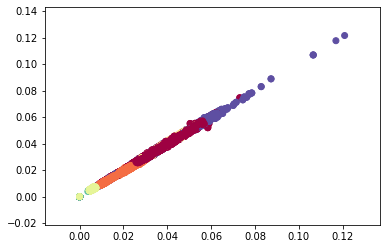

In [80]:
df = pd.concat([main_df, df_class], axis=1, sort=False)
df_masked = df[(df[['Target']] != 0).all(axis=1)]
X = df_masked.drop(columns=['Target']).values
y = df_masked['Target'].values
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Spectral')
plt.show()

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.03513231500983238]
    G: [0.0, 0.038909558206796646]
    B: [0.0, 0.03554316982626915]
>

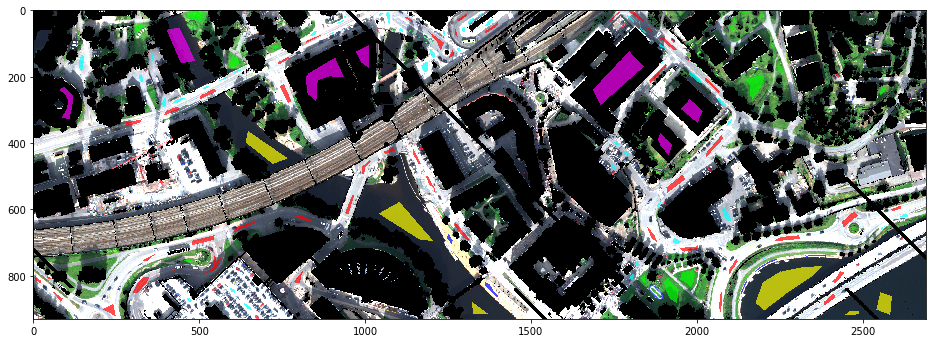

In [81]:
view = imshow(img, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)), figsize=(16, 16), classes=gt)
view.set_display_mode('overlay')
view.class_alpha = 0.7
view.show_data

In [82]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [6, 7],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [84]:
random_forest = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=6, n_jobs= -1)
random_forest.fit(X_train, y_train)
pred = random_forest.predict(X_test)
accuracy_score(y_test, pred)

0.9782696324526365

In [85]:
random_forest2 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=6, n_jobs= -1)
random_forest2.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [86]:
X_data = df.drop(columns=['Target']).values
X_data_scaled = scaler.transform(X_data)

In [87]:
y_pred = random_forest2.predict(X_data_scaled)

In [88]:
predicted_hsi_mask = y_pred.reshape(img.shape[0], img.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.03513231500983238]
    G: [0.0, 0.038909558206796646]
    B: [0.0, 0.03554316982626915]
>

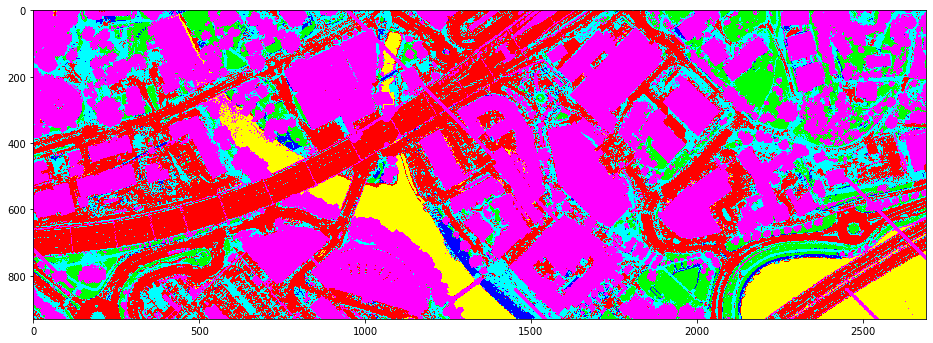

In [89]:
#full_image = envi.open('../hyperImage/reflectance/09_VNIR_CLIPPED_ATM_COR_POLISHED.hdr', '../hyperImage/reflectance/09_VNIR_CLIPPED_ATM_COR_POLISHED')
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [39]:
road = (predicted_hsi_mask == 1).astype(int)

In [40]:
from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.3,
)
#viewer = ImageViewer(edges)
#viewer.show()
road_edges = edges.astype(int)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.03513231500983238]
    G: [0.0, 0.038909558206796646]
    B: [0.0, 0.03554316982626915]
>

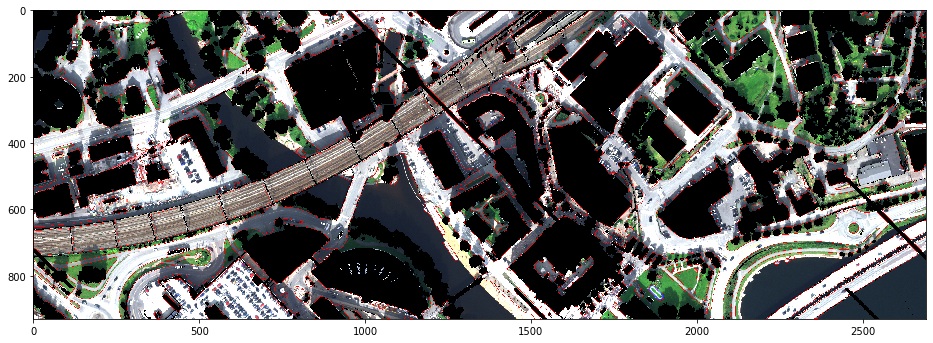

In [41]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# Using Lidar Data Only

In [26]:
#import lidar dem and intensity image 
l_intensity_data = Image.open('../hyperImage/clipped_intensity.tif')
l_intensity = np.array(l_intensity_data)
df_intensity = pd.DataFrame(l_intensity.reshape(-1, 1))
string = "Lidar Intensity"
df_intensity.columns = [string]

l_dsm_data = Image.open('../hyperImage/nDSM.tif')
l_dsm = np.array(l_dsm_data)
df_dsm = pd.DataFrame(l_dsm.reshape(-1, 1))
string = "Lidar nDSM"
df_dsm.columns = [string]

In [27]:
df_lidar = pd.concat([df_intensity, df_dsm, df_class], axis=1, sort=False)
df_lidar_masked =  df_lidar[(df_lidar[['Target']] != 0).all(axis=1)]
X = df_lidar_masked.drop(columns=['Target']).values
y = df_lidar_masked['Target'].values

In [28]:
scaler1 = MinMaxScaler()
scaler1.fit(X)
X_scaled = scaler1.transform(X)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)

In [30]:
random_forest2 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest2.fit(X_train, y_train)
pred = random_forest2.predict(X_test)
accuracy_score(y_test, pred)

0.7779007052966395

In [31]:
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features=0.25,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [32]:
np.isnan(df_lidar).sum()

Lidar Intensity    0
Lidar nDSM         0
Target             0
dtype: int64

In [33]:
X_lidar_data = df_lidar.drop(columns=['Target']).values
S_lidar_data_scaled = scaler1.transform(X_lidar_data)
y_pred_lidar = random_forest3.predict(S_lidar_data_scaled)
predicted_lidar_mask = y_pred_lidar.reshape(931, 2694)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.04192280024290085]
    G: [0.0, 0.0456819124519825]
    B: [0.0, 0.0417693667113781]
>

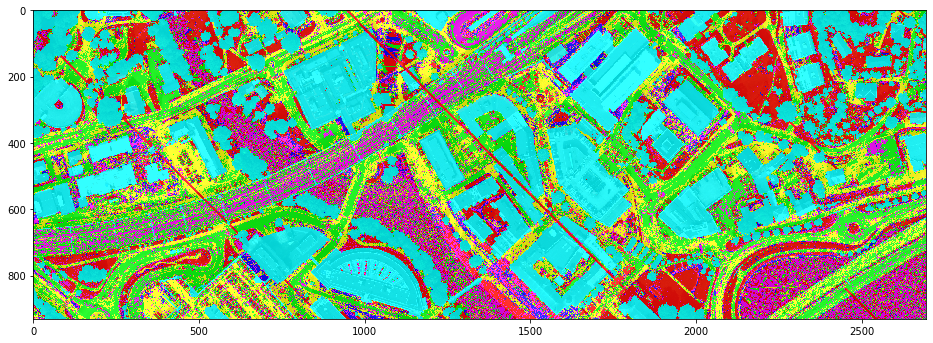

In [34]:
view = imshow(full_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 0.8
view.show_data

In [35]:
road = (predicted_lidar_mask == 2).astype(int)

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.3,
)

road_edges = edges.astype(int)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.04192280024290085]
    G: [0.0, 0.0456819124519825]
    B: [0.0, 0.0417693667113781]
>

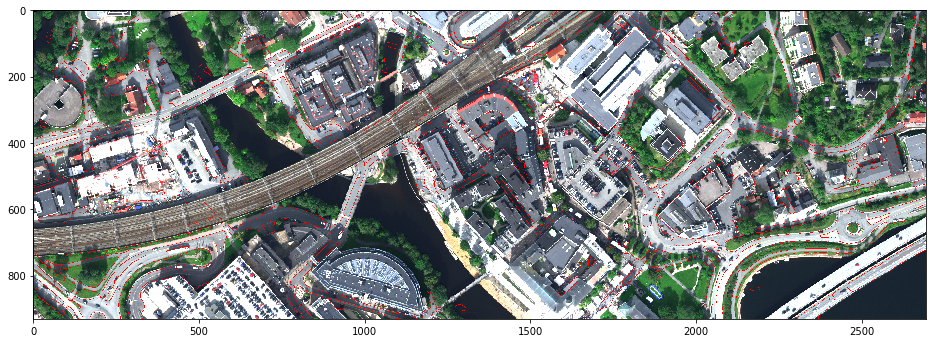

In [37]:
view = imshow(full_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# Using  hyperspectral and lidar data 

In [38]:
#merge with HSI dataframe and lidar dataframe

In [39]:
df_lid_hsi = pd.concat([main_df, df_intensity, df_dsm, df_class], axis=1, sort=False)

In [40]:
df_masked =  df_lid_hsi[(df_lid_hsi[['Target']] != 0).all(axis=1)]
X = df_masked.drop(columns=['Target']).values
y = df_masked['Target'].values

In [41]:
scaler3 = MinMaxScaler()
scaler3.fit(X)
X_scaled = scaler3.transform(X)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_train, y_train)
pred = random_forest3.predict(X_test)
accuracy_score(y_test, pred)

0.989351403678606

In [43]:
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features=0.25,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [44]:
X_data = df_lid_hsi.drop(columns=['Target']).values
X_data_scaled = scaler3.transform(X_data)

In [45]:
y_pred = random_forest3.predict(X_data_scaled)

In [46]:
predicted_hsi_lidar_mask = y_pred.reshape(931, 2694)

In [47]:
road = (predicted_hsi_lidar_mask == 2).astype(int)

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.4,
)
road_edges = edges.astype(int)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.04192280024290085]
    G: [0.0, 0.0456819124519825]
    B: [0.0, 0.0417693667113781]
>

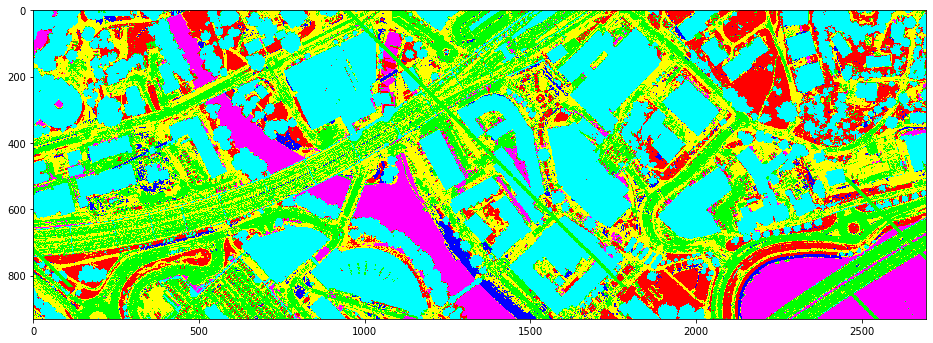

In [142]:
view = imshow(full_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# Validation data

In [119]:
val_image = envi.open('../hyperImage/08_buildingmaskedout.hdr', '../hyperImage/08_buildingmaskedout')
val_img = val_image.load()
val_img.shape

(931, 2763, 186)

In [120]:
#compute PCA on the image 
pc = principal_components(image)
pc_0999 = pc.reduce(fraction=0.999)
val_img_pc = pc_0999.transform(val_image)
val_img_pc.shape

Covariance.....  0.0Covariance.....  0.0Covariance.....done  


(931, 2763, 15)

In [121]:
#NDVI calculation of the image 
vi = ndvi(val_image, 76, 105)
data_ndvi = np.nan_to_num(vi)

/Users/rabinsenchuro/opt/anaconda3/lib/python3.7/site-packages/spectral/algorithms/algorithms.py:1216: RuntimeWarning: invalid value encountered in true_divide
  return (n - r) / (n + r)


In [122]:
l_intensity_data = Image.open('../hyperImage/08intensity.tif')
l_intensity = np.array(l_intensity_data)
df_intensity = pd.DataFrame(l_intensity.reshape(-1, 1))
string = "Lidar Intensity"
df_intensity.columns = [string]

l_dsm_data = Image.open('../hyperImage/08nDSM.tif')
l_dsm = np.array(l_dsm_data)
df_dsm = pd.DataFrame(l_dsm.reshape(-1, 1))
string = "Lidar nDSM"
df_dsm.columns = [string]

In [123]:
## Combine PCA,and ndvi DATA
pc_img = val_img_pc.load()
df_pca = pd.DataFrame(pc_img.reshape(-1, val_img_pc.shape[2]))
string = "PC"
df_pca.columns = [string + str(n) for n in range(1, val_img_pc.shape[2]+1)]
df_ndvi = pd.DataFrame(data_ndvi.reshape(-1, 1))
string = "NDVI"
df_ndvi.columns = [string]
#Concatenate 3 dataframe 
main_df = pd.concat([df_pca, df_ndvi], axis=1, sort=False)

In [124]:
## Class image
gt_data = Image.open('../hyperImage/shapefile/8class.tif')
gt = np.array(gt_data)
gt.shape

(931, 2763)

In [125]:
np.unique(gt)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [126]:
df_class = pd.DataFrame(gt.reshape(-1, 1))
string = "Target"
df_class.columns = [string]

In [127]:
df_lid_hsi = pd.concat([main_df, df_intensity, df_dsm, df_class], axis=1, sort=False)

In [128]:
df_masked =  df_lid_hsi[(df_lid_hsi[['Target']] != 0).all(axis=1)]
X = df_masked.drop(columns=['Target']).values
y = df_masked['Target'].values

In [129]:
scaler4 = MinMaxScaler()
scaler4.fit(X)
X_scaled = scaler4.transform(X)

In [130]:
val_pred = random_forest3.predict(X_scaled)

In [131]:
accuracy_score(y, val_pred)

0.18761754884274365

In [132]:
df_lid_hsi

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0       -0.167815  0.003759  0.006441 -0.000912 -0.000357 -0.000379  0.001098   
1       -0.167815  0.003759  0.006441 -0.000912 -0.000357 -0.000379  0.001098   
2       -0.167815  0.003759  0.006441 -0.000912 -0.000357 -0.000379  0.001098   
3       -0.167815  0.003759  0.006441 -0.000912 -0.000357 -0.000379  0.001098   
4       -0.167815  0.003759  0.006441 -0.000912 -0.000357 -0.000379  0.001098   
...           ...       ...       ...       ...       ...       ...       ...   
2572348  0.140847  0.250572 -0.014883  0.010477 -0.002429  0.006255  0.008417   
2572349  0.101646  0.219507 -0.014658  0.010706 -0.005402  0.008202  0.008211   
2572350  0.101646  0.219507 -0.014658  0.010706 -0.005402  0.008202  0.008211   
2572351  0.115590  0.216365 -0.011883  0.010233 -0.008604  0.004298  0.006636   
2572352  0.276720  0.367594 -0.018593  0.015008  0.002795  0.010610  0.014637   

              PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0        0.001600 -0.000848 -0.000542 -0.000661  0.000488 -0.000833 -0.000485   
1        0.001600 -0.000848 -0.000542 -0.000661  0.000488 -0.000833 -0.000485   
2        0.001600 -0.000848 -0.000542 -0.000661  0.000488 -0.000833 -0.000485   
3        0.001600 -0.000848 -0.000542 -0.000661  0.000488 -0.000833 -0.000485   
4        0.001600 -0.000848 -0.000542 -0.000661  0.000488 -0.000833 -0.000485   
...           ...       ...       ...       ...       ...       ...       ...   
2572348 -0.013125  0.002819  0.011210 -0.005920  0.004905 -0.002447 -0.006038   
2572349 -0.012557  0.003058  0.011319 -0.006399  0.003251 -0.003903 -0.007612   
2572350 -0.012557  0.003058  0.011319 -0.006399  0.003251 -0.003903 -0.007612   
2572351 -0.011691  0.003013  0.009366 -0.004667  0.002439 -0.002726 -0.006061   
2572352 -0.018066  0.003012  0.016848 -0.011521  0.008669 -0.005473 -0.012993   

             PC15      NDVI  Lidar Intensity  Lidar nDSM  Target  
0       -0.000161  0.000000              7.0    7.630000       0  
1       -0.000161  0.000000              6.0    7.630000       0  
2       -0.000161  0.000000              7.0    7.610000       0  
3       -0.000161  0.000000              6.0    7.650000       0  
4       -0.000161  0.000000              6.0    7.650000       0  
...           ...       ...              ...         ...     ...  
2572348  0.001289  0.821181              2.0    0.289999       0  
2572349  0.003838  0.803266              3.0    0.289999       0  
2572350  0.003838  0.803266              3.0    0.890001       0  
2572351  0.003197  0.761929              2.0    0.699999       0  
2572352  0.003021  0.821872              3.0    0.699999       0  

[2572353 rows x 19 columns]

In [133]:
X_data = df_lid_hsi.drop(columns=['Target']).values
X_data_scaled = scaler3.transform(X_data)

In [134]:
val_pred_full = random_forest3.predict(X_data_scaled)

In [135]:
predicted_hsi_lidar_mask_val = val_pred_full.reshape(931, 2763)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.029470421373844147]
    G: [0.0, 0.033217426389455795]
    B: [0.0, 0.03012710250914097]
>

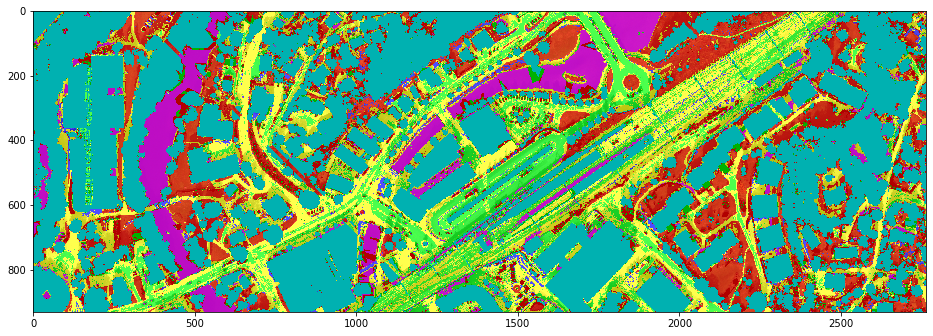

In [136]:
view = imshow(val_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_lidar_mask_val)
view.set_display_mode('overlay')
view.class_alpha = 0.7
view.show_data

In [137]:
val_full_image = envi.open('../hyperImage/08_VNIR_full.hdr', '../hyperImage/08_VNIR_full')


In [138]:
road = (predicted_hsi_lidar_mask_val == 2).astype(int)

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.4,
)
road_edges = edges.astype(int)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0015348768793046474, 0.03608981519937515]
    G: [0.002854337217286229, 0.0400165393948555]
    B: [0.004065426532179117, 0.037028100341558456]
>

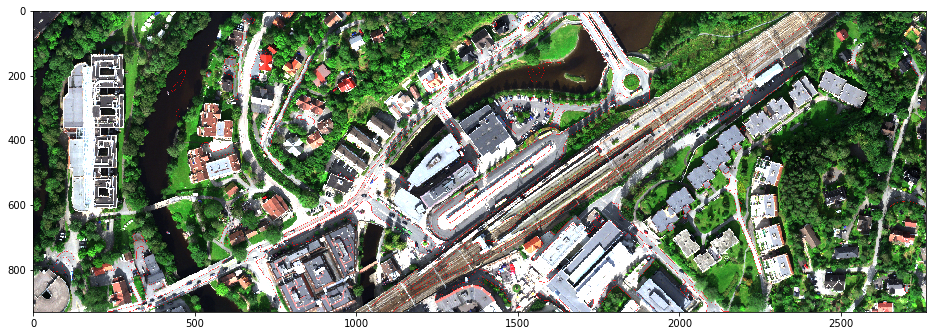

In [141]:
view = imshow(val_full_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 0.7
view.show_data